# Курсовой проект от Megafon

**Задача**.
У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
<br>
**Метрика**.
Скоринг будет осуществляться функцией _f1_, невзвешенным образом, как например делает функция _sklearn.metrics.f1_score(…, average=’macro’)_.

## План работы

**Построение модели классификации**
1. [Работа с данными](#eda)
* обзор данных
* разбиение признакового пространства по типам
* анализ данных
* merge данных об отклике и профильных признаков
2. [Разделение тренировочного датасета](#train_test_split)
3. [Построение baseline-модели](#baseline)
4. [Подбор моделей и подходов для улучшения результатов baseline](#improve_baseline)
8. [Тюнинг гиперпараметров лучшей модели](#tuning)
6. [Отбор признаков по важности](#feature_importances)
10. [Сбор в pipeline и прогноз на тестовом датасете](#test_prediction)</a>
<br>
**Формат отчёта**
<br>
Результаты работы модели необходимо записать в файл _answers_test.csv_. В этом файле должны находится 4 столбца: _buy_time, id, vas_id и target_. _Target_ можно записать как вероятность подключения услуги. Оформить результат согласно [инструкции](https://docs.google.com/document/d/1Lr4AfRfTRhoJ-GXOj4kcLWsrWS4AEd0_iTNW-uJFLrc/edit#).

## Импорты и определение функций

In [227]:
#!pip install imblearn catboost

In [271]:
import itertools
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

from imblearn.under_sampling import NearMiss
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [258]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [262]:
class DataEnricher(BaseEstimator, TransformerMixin):
    def __init__(self, data, features):
        self.data = data
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # смержим датасеты
        data_feat = pd.merge(self.data, self.features, how='left', on=['id'])

        # и избавимся от устаревших данных
        data_feat = data_feat.sort_values(by=['id', 'buy_time_y'], ascending=False).drop_duplicates(subset=['id', 'vas_id', 'buy_time_x'])
        return data_feat

In [128]:
def run_cv(estimator, cv, X, y, scoring='f1_macro', model_name=''):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))

In [129]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

In [130]:
def plot_confusion_matrix(cm, classes, model_name="", normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [232]:
def get_important_features(importance, names, model_type):
    
    # create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    # create a DataFrame using a Dictionary
    data={'feature_names': feature_names,
          'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    # sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    # and crop which non-important
    fi_df = fi_df[fi_df['feature_importance'] > 1e-2]
    
    return fi_df['feature_names'].tolist()

## <a id='eda'>Работа с данными</a>

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.<br><br>
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.<br><br>
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:<br>
* data_train.csv: id, vas_id, buy_time, target
* features.csv.zip: id, [feature_list]

И тестовый набор:<br>
* data_test.csv: id, vas_id, buy_time<br>

**target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.<br>
**buy_time** - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.<br>
**id** - идентификатор абонента<br>
**vas_id** - подключаемая услуга

In [272]:
# константы
RANDOM_STATE = 42
TARGET = 'target'

# input
TRAIN_DATASET_PATH = './data_train.csv'
TEST_DATASET_PATH = './data_test.csv'
FEATURES_DATASET_PATH = '~/Downloads/features.csv'

# output
MODEL_PATH = './model.pkl'
PIPELINE_PATH = './pipeline.pkl'
ANSWERS_PATH = './answers_test.csv'

### обзор данных

In [134]:
# оценим признаки и размер тренировочного датасета
data_train = pd.read_csv(TRAIN_DATASET_PATH)
data_train.name = 'train'
data_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [135]:
data_train.shape

(831653, 5)

In [256]:
# оценим признаки и размер тестового датасета
data_test = pd.read_csv(TEST_DATASET_PATH)
data_test.name = 'test'
data_test.head(3)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400


In [257]:
data_test.shape

(71231, 4)

In [138]:
data_feat = pd.read_csv(FEATURES_DATASET_PATH, sep='\t')
data_feat.name = 'features'
data_feat.head(3)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [139]:
data_feat.shape

(4512528, 256)

In [ ]:
# в каждом датасете проверим признак 'Unnamed: 0' на совпадение с индексами строк
for dataset in [data_train, data_test, data_feat]:
    if np.array_equal(dataset['Unnamed: 0'], range(dataset.shape[0])):
        # и сбросим, если они совпадают
        dataset.drop('Unnamed: 0', axis=1, inplace=True)

### разбиение признакового пространства по типам

In [141]:
f_unique = data_feat.drop(['id', 'buy_time'], axis=1).apply(lambda x: x.nunique(dropna=False))
f_unique.shape

(253,)

<AxesSubplot:title={'center':'Распределение уникальных значений признаков'}>

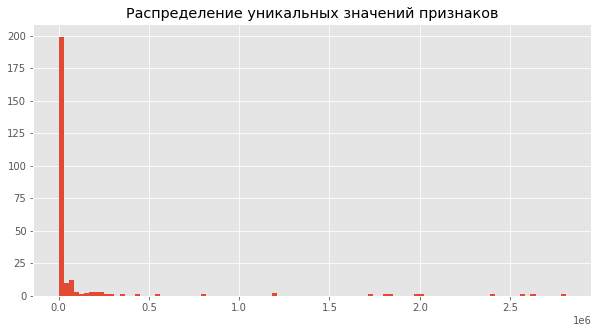

In [142]:
plt.title('Распределение уникальных значений признаков')
plt.style.use('ggplot')
f_unique.hist(bins=100, figsize=(10, 5))

In [143]:
f_all = set(f_unique.index.tolist())
len(f_all)

253

#### константные

In [144]:
f_const = set(f_unique[f_unique == 1].index.tolist())
len(f_const)

5

#### вещественные

In [145]:
f_num = (data_feat.fillna(0).astype(int).sum() - data_feat.fillna(0).sum()).abs()
f_num = set(f_num[f_num > 0].index.tolist())
len(f_num)

247

In [146]:
f_other = f_all - (f_num | f_const)
len(f_other)

1

#### бинарные

In [147]:
f_binary = set(data_feat.loc[:, f_other].columns[(
                   (data_feat.loc[:, f_other].max() == 1) & \
                   (data_feat.loc[:, f_other].min() == 0) & \
                   (data_feat.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

#### категориальные

In [148]:
f_cat = set(f_unique.loc[f_other][f_unique.loc[f_other] <= 100].index.tolist())
len(f_cat)

1

#### проверим, покрыли ли мы всё признаковое пр-во типами

In [149]:
if f_unique.shape[0] == len(f_const) + len(f_num) + len(f_binary) + len(f_cat):
    print(True)

True


In [150]:
print('f_all:', len(f_all), '\n')

print('f_const:', len(f_const))
print('f_num:', len(f_num))
print('f_cat:', len(f_cat))

f_cat, f_num = list(f_cat), list(f_num)

f_all: 253 

f_const: 5
f_num: 247
f_cat: 1


### анализ данных

In [151]:
# проверим дубли в строках
for dataset in [data_train, data_test, data_feat]:
    print(f'Кол-во дублей в {dataset.name}: {dataset.duplicated().sum()}')

Кол-во дублей в train: 0
Кол-во дублей в test: 0
Кол-во дублей в features: 0


In [152]:
# выявим кол-во пропусков в признаках
for dataset in [data_train, data_test, data_feat]:
    print(f'{dataset.name}: {(dataset.isnull().sum()).sum()}')

train: 0
test: 0
features: 0


**Вывод**: пропусков и дублей не обнаружено

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

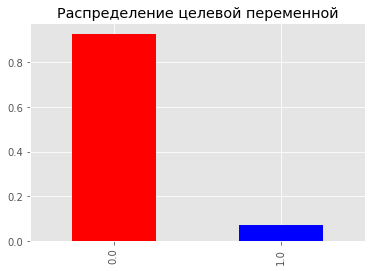

In [153]:
# оценим распределение целевой переменной
(data_train[TARGET].value_counts() / data_train[TARGET].shape[0]).plot(kind='bar', title='Распределение целевой переменной', color=list('rb'))
data_train[TARGET].value_counts() / data_train[TARGET].shape

**Вывод**: распределение очень сильно разбалансировано, необходимо учесть это на последующих этапах

### merge данных об отклике и признаков профиля

In [154]:
data_train_feat = pd.merge(data_train, data_feat, how='left', on=['id'])
data_train_feat

,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,1541970000,-31.559971,327.360888,-45.500786,274.753202,-50.918246,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,1531083600,547.270029,238.430888,533.329214,274.803202,527.911754,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,1534107600,0.0,1543179600,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,1535922000,0.0,1533502800,54.880029,12.970888,54.079214,-9.116798,48.661754,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,1535922000,0.0,1543179600,45.160029,295.240888,64.679214,344.283202,59.261754,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,3812226,2.0,1546203600,0.0,1532898000,29.750029,6.200888,24.279214,-37.936798,18.861754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
860048,2480469,2.0,1546203600,0.0,1532293200,-89.179971,-56.499112,-103.120786,-109.106798,-108.538246,...,-66.373846,-321.770792,-25.996269,62.369552,1167.252276,41.167111,-0.694428,54.824067,-0.45614,0.0
860049,158236,2.0,1546203600,0.0,1538946000,-96.799971,62.140888,-110.740786,9.533202,-116.158246,...,-683.373846,-470.770792,-25.996269,-37.630448,99.252276,178.167111,-0.694428,191.824067,-0.45614,0.0
860050,1825525,2.0,1546203600,0.0,1533502800,-96.799971,-81.919112,-110.740786,-128.596798,-116.158246,...,1018.626154,1367.229208,-24.996269,-35.630448,-237.747724,-21.832889,-0.694428,-8.175933,-0.45614,1.0


In [155]:
print('Процент признаков, принимающих NaN-значения: %d%%' % float((data_train_feat.isnull().sum() > 0).sum() / data_train_feat.shape[1] * 100))

Процент признаков, принимающих NaN-значения: 0%


In [156]:
print(f'При слиянии таблиц образовалось {data_train_feat.shape[0] - data_train.shape[0]} новых строк,')
print(f'из них полных дублей {data_train_feat.duplicated().sum()}')

При слиянии таблиц образовалось 28399 новых строк,
из них полных дублей 0


**Вывод**: т.к. новые строки появились ввиду изменения профиля потребления абонента со временем, то для нас бОльшую ценность несут самые свежие данные.

In [157]:
# избавимся от устаревших данных
data_train_feat = data_train_feat.sort_values(by=['id', 'buy_time_y'], ascending=False).drop_duplicates(subset=['id', 'vas_id', 'buy_time_x', 'target'])
print(f'Кол-во новых строк после удаления устаревших: {data_train_feat.shape[0] - data_train.shape[0]}')

Кол-во новых строк после удаления устаревших: 0


## <a id='train_test_split'>Разделение тренировочного датасета</a>

In [158]:
# избавимся от константных признаков
data_train_feat.drop(f_const, axis=1, inplace=True)

In [159]:
X = data_train_feat.drop(TARGET, axis=1)
y = data_train_feat[TARGET]

train_idx, test_idx = train_test_split(data_train_feat.index, test_size=0.25, random_state=RANDOM_STATE)

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

print('Train:')
print(y.loc[train_idx].value_counts() / y.loc[train_idx].shape[0], '\n')
print('Test:')
print(y.loc[test_idx].value_counts() / y.loc[test_idx].shape[0], '\n')

Train:
0.0    0.927996
1.0    0.072004
Name: target, dtype: float64 

Test:
0.0    0.926537
1.0    0.073463
Name: target, dtype: float64 



## <a id='baseline'>Построение baseline-модели</a>

In [160]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [161]:
# оценим качество модели, используя кросс-валидацию
run_cv(rf_model, kfold_cv, X_train, y_train, model_name='Baseline Random Forest')

Baseline Random Forest: f1_macro = 0.48 (+/- 0.00)


In [162]:
rf_model.fit(X_train, y_train)
rf_y_preds = rf_model.predict_proba(X_test)[:, 1]

In [163]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_y_preds)
  
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best threshold: %.3f' % thresholds[ix])

Best threshold: 0.280


Baseline Random Forest AUC_PR = 0.455


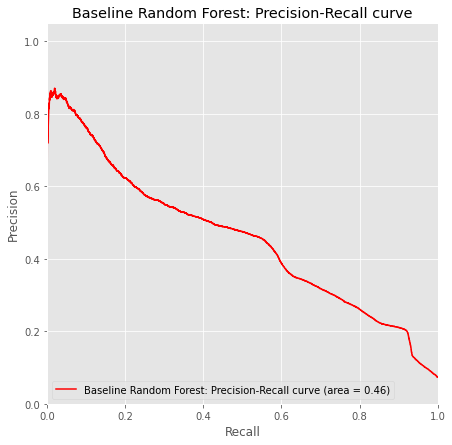

In [164]:
plt.figure(figsize=(7, 7))
plot_precision_recall_curve(recall, precision, 'Baseline Random Forest', color='r')
print('Baseline Random Forest AUC_PR = %.3f' % auc(recall, precision))

Confusion matrix, without normalization
[[192637      3]
 [ 15274      0]]


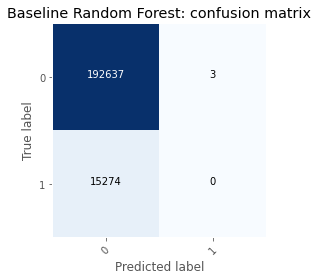

In [165]:
cm = confusion_matrix(y_test, rf_y_preds >= thresholds[ix])
plot_confusion_matrix(cm, classes=['0', '1'], model_name='Baseline Random Forest')

In [166]:
print(classification_report(y_test, rf_y_preds >= thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192640
         1.0       0.00      0.00      0.00     15274

    accuracy                           0.93    207914
   macro avg       0.46      0.50      0.48    207914
weighted avg       0.86      0.93      0.89    207914



**Вывод**: из-за сильного дисбаланса значений целевой переменной, модель игнорирует класс 1.

## <a id='improve_baseline'>Подбор моделей и подходов для улучшения результатов baseline</a>

#### сбалансируем классы

In [167]:
# для начала сбалансируем значения целевой переменной
nm = NearMiss()
X_train_miss, y_train_miss = nm.fit_resample(X_train, y_train.ravel())

print('1: {}'.format(sum(y_train_miss >= thresholds[ix])))
print('0: {}'.format(sum(y_train_miss < thresholds[ix])))

1: 44912
0: 44912


In [168]:
# проверим гипотезу о необходимости сбалансировать значения целевой переменной
rf_model.fit(X_train_miss, y_train_miss)
rf_y_preds_nm = rf_model.predict_proba(X_test)[:, 1]

In [169]:
print(classification_report(y_test, rf_y_preds_nm >= thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.99      0.11      0.19    192640
         1.0       0.08      0.98      0.15     15274

    accuracy                           0.17    207914
   macro avg       0.53      0.55      0.17    207914
weighted avg       0.92      0.17      0.19    207914



**Вывод**: общее качество прогнозиорования упало, но теперь модель не избегает распознавания 1.

#### попробуем модель посложнее

In [175]:
# catboost умеет работать с категориальными признаками 'из коробки', так что передадим их гиперпараметром
X_train_miss[f_cat] = X_train_miss[f_cat].apply(str)
X_test[f_cat] = X_test[f_cat].apply(str)

In [174]:
catb = CatBoostClassifier(
    cat_features=f_cat,
    eval_metric='F1',
    silent=True,
    random_state=RANDOM_STATE)
catb.fit(X_train_miss, y_train_miss)

In [185]:
catb_y_preds_nm = catb.predict(X_test)
print(classification_report(y_test, catb_y_preds_nm))

              precision    recall  f1-score   support

         0.0       0.99      0.35      0.52    192640
         1.0       0.10      0.93      0.18     15274

    accuracy                           0.40    207914
   macro avg       0.54      0.64      0.35    207914
weighted avg       0.92      0.40      0.50    207914



**Вывод**: нам удалось добиться улучшения качества предсказаний для модели не игнорирующей 1, но общее качество всё ещё ниже, чем у модели игнорирующей 1.

## <a id='tuning'>Тюнинг гиперпараметров лучшей модели</a>

In [177]:
params = {'n_estimators':[50, 100, 300, 700, 1000, 1500],
          'max_depth':[3, 5, 7]}
cv = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

In [82]:
rs = RandomizedSearchCV(
    catb,
    params,
    scoring='f1',
    cv=cv,
    n_jobs=-1)
rs.fit(X_train_miss, y_train_miss)

rs.best_params_

{'n_estimators': 1500, 'max_depth': 5}

In [178]:
catb = CatBoostClassifier(
    n_estimators=1500,
    max_depth=5,
    cat_features=f_cat,
    eval_metric='F1',
    silent=True,
    random_state=RANDOM_STATE)
catb.fit(X_train_miss, y_train_miss)

In [182]:
catb_y_preds = catb.predict(X_test)
print(classification_report(y_test, catb_y_preds))

              precision    recall  f1-score   support

         0.0       0.99      0.35      0.52    192640
         1.0       0.10      0.93      0.18     15274

    accuracy                           0.40    207914
   macro avg       0.54      0.64      0.35    207914
weighted avg       0.92      0.40      0.50    207914



Confusion matrix, without normalization
[[ 68075 124565]
 [  1036  14238]]


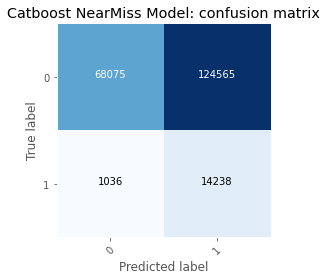

In [184]:
cm = confusion_matrix(y_test, catb_y_preds)
plot_confusion_matrix(cm, classes=['0', '1'], model_name='Catboost NearMiss Model')

**Вывод**: модель в текущем состоянии показывает не лучший результат по метрике F1, но опознаёт некоторое количество TP-событий. Попробуем увеличить целевую метрику без потери вышеуказанного свойства.

## <a id='feature_importances'>Отбор признаков по важности</a>

In [233]:
important_features = get_important_features(catb.get_feature_importance(), X_train.columns, 'Catboost NearMiss Model')

In [239]:
print(f'Нам удалось сократить датасэт на {X_train.shape[1] - len(important_features)} признаков')

Нам удалось сократить датасэт на 111 признаков


In [241]:
catb_fin = CatBoostClassifier(
    n_estimators=1500,
    max_depth=5,
    eval_metric='F1',
    silent=True,
    random_state=RANDOM_STATE)

catb_fin.fit(X_train_miss[important_features], y_train_miss)

In [243]:
catb_fin_y_preds = catb_fin.predict(X_test[important_features])
print(classification_report(y_test, catb_fin_y_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.34      0.51    192640
         1.0       0.10      0.93      0.18     15274

    accuracy                           0.39    207914
   macro avg       0.54      0.64      0.34    207914
weighted avg       0.92      0.39      0.48    207914



Baseline: AUC_PR = 0.455
Baseline: AUC_ROC = 0.883
Catboost Final Model: AUC_PR = 0.519
Catboost Final Model: AUC_ROC = 0.637


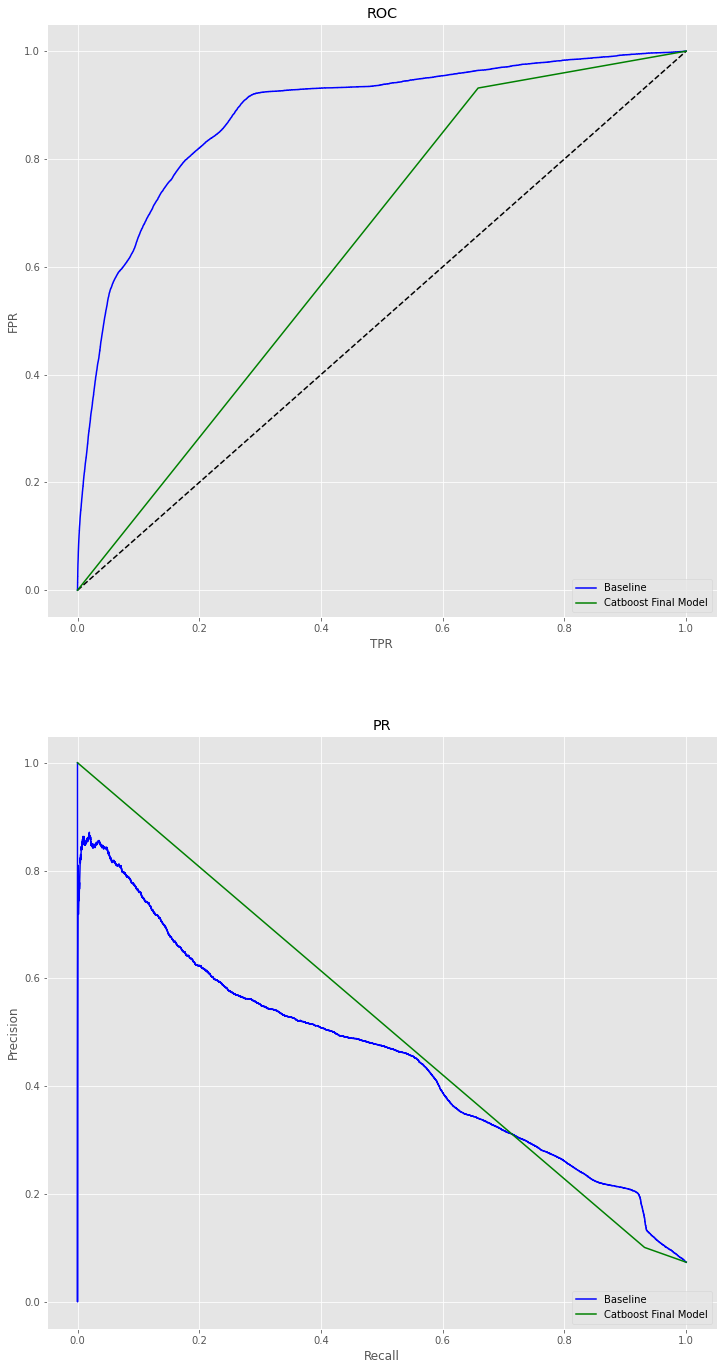

In [246]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, rf_y_preds)
precision, recall, pr_thresholds = precision_recall_curve(y_test, rf_y_preds)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, catb_fin_y_preds)
precision, recall, pr_thresholds = precision_recall_curve(y_test, catb_fin_y_preds)
ax1.plot(fpr, tpr, label="Catboost Final Model", color='g')
ax2.plot(recall, precision, label="Catboost Final Model", color='g')
print("Catboost Final Model: AUC_PR = %.3f" % auc(recall, precision))
print("Catboost Final Model: AUC_ROC = %.3f" % auc(fpr, tpr))

ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

**Вывод**: отбор признаков не дал профита в финальной метрике, но позволил уменьшить модель почти в 2 раза. Имеет смысл остановиться на этом варианте.

In [ ]:
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(catb_fin, f)

## <a id='test_prediction'>Сбор в pipeline и прогноз на тестовом датасете</a>

In [266]:
final_estimator = Pipeline([('enrich_data', DataEnricher(data_test, data_feat)),
                            ('cs', ColumnSelector(columns=important_features)),
                            ('catb', catb_fin)
])

test_preds = final_estimator.predict_proba(data_test)

answers = data_test.join(pd.DataFrame(test_preds)[1])
answers.rename(columns={1: TARGET}, inplace=True)

In [320]:
with open(PIPELINE_PATH, 'wb') as f:
    pickle.dump(final_estimator, f)

In [321]:
with open(ANSWERS_PATH, 'wb') as f:
    answers.to_csv(f, encoding='utf-8', index=False)